In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cropped-final-kymograms/final kymograms cropped/functional/552_crop6.png
/kaggle/input/cropped-final-kymograms/final kymograms cropped/functional/267_crop16.png
/kaggle/input/cropped-final-kymograms/final kymograms cropped/functional/50_crop12.png
/kaggle/input/cropped-final-kymograms/final kymograms cropped/functional/405_crop11.png
/kaggle/input/cropped-final-kymograms/final kymograms cropped/functional/598_crop9.png
/kaggle/input/cropped-final-kymograms/final kymograms cropped/functional/435_crop2.png
/kaggle/input/cropped-final-kymograms/final kymograms cropped/functional/435_crop14.png
/kaggle/input/cropped-final-kymograms/final kymograms cropped/functional/373_crop8.png
/kaggle/input/cropped-final-kymograms/final kymograms cropped/functional/175_crop13.png
/kaggle/input/cropped-final-kymograms/final kymograms cropped/functional/107_crop6.png
/kaggle/input/cropped-final-kymograms/final kymograms cropped/functional/72_crop15.png
/kaggle/input/cropped-final-kymograms/f

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import os, shutil, random, time, copy
from pathlib import Path
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import inception_v3, Inception_V3_Weights
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# ===========================
# Dataset Split & Oversampling
# ===========================
src_dir = Path("/kaggle/input/cropped-final-kymograms/final kymograms cropped")
dst_dir = Path("/kaggle/working/tertiary_split")

# Step 1: Gather all images with class labels
all_images = []
for cls in os.listdir(src_dir):
    cls_dir = src_dir / cls
    for img in cls_dir.glob("*.png"):
        all_images.append((img, cls))

# Step 2: Global split - 15% test
trainval, test = train_test_split(all_images, test_size=0.15, random_state=42, stratify=[label for _, label in all_images])
# Step 3: Split remaining into 70% train, 30% val
train, val = train_test_split(trainval, test_size=0.15, random_state=42, stratify=[label for _, label in trainval])

# Step 4: Copy images
def copy_images(split_name, data):
    for img_path, cls in data:
        split_dir = dst_dir / split_name / cls
        split_dir.mkdir(parents=True, exist_ok=True)
        shutil.copy(img_path, split_dir / img_path.name)

copy_images("train", train)
copy_images("val", val)
copy_images("test", test)

# Step 5: Oversample training set
train_dir = Path("/kaggle/working/tertiary_split/train")
class_counts = {cls.name: len(list(cls.glob("*.png"))) for cls in train_dir.iterdir()}
max_count = max(class_counts.values())

for cls_name, count in class_counts.items():
    cls_path = train_dir / cls_name
    images = list(cls_path.glob("*.png"))
    if count < max_count:
        needed = max_count - count
        to_duplicate = random.choices(images, k=needed)
        for i, img in enumerate(to_duplicate):
            new_name = cls_path / f"{img.stem}_dup{i}{img.suffix}"
            shutil.copy(img, new_name)

print("✅ Training set balanced by oversampling.")


✅ Training set balanced by oversampling.


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 161MB/s]  


Epoch 1/30 - 277s - accuracy: 0.8256 - loss: 0.5490 - val_accuracy: 0.9445 - val_loss: 0.1413
Epoch 2/30 - 285s - accuracy: 0.9761 - loss: 0.1036 - val_accuracy: 0.9873 - val_loss: 0.0378
Epoch 3/30 - 285s - accuracy: 0.9864 - loss: 0.0611 - val_accuracy: 0.9929 - val_loss: 0.0237
Epoch 4/30 - 285s - accuracy: 0.9895 - loss: 0.0453 - val_accuracy: 0.9937 - val_loss: 0.0382
Epoch 5/30 - 285s - accuracy: 0.9909 - loss: 0.0404 - val_accuracy: 0.9937 - val_loss: 0.0170
Epoch 6/30 - 285s - accuracy: 0.9887 - loss: 0.0499 - val_accuracy: 0.9976 - val_loss: 0.0234
Epoch 7/30 - 285s - accuracy: 0.9950 - loss: 0.0228 - val_accuracy: 0.9968 - val_loss: 0.0226
Epoch 8/30 - 286s - accuracy: 0.9918 - loss: 0.0360 - val_accuracy: 0.9960 - val_loss: 0.0155
Epoch 9/30 - 285s - accuracy: 0.9912 - loss: 0.0476 - val_accuracy: 0.9976 - val_loss: 0.0082
Epoch 10/30 - 285s - accuracy: 0.9903 - loss: 0.0440 - val_accuracy: 0.9937 - val_loss: 0.0230
Epoch 11/30 - 285s - accuracy: 0.9966 - loss: 0.0204 - val_

/tmp/ipykernel_31/1717044644.py:132: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_inceptionv3.pth"))



Confusion Matrix:
 [[314   2   0]
 [  1 929   3]
 [  0   0 236]]

Classification Report:
               precision    recall  f1-score   support

  functional       1.00      0.99      1.00       316
     healthy       1.00      1.00      1.00       933
     organic       0.99      1.00      0.99       236

    accuracy                           1.00      1485
   macro avg       0.99      1.00      1.00      1485
weighted avg       1.00      1.00      1.00      1485



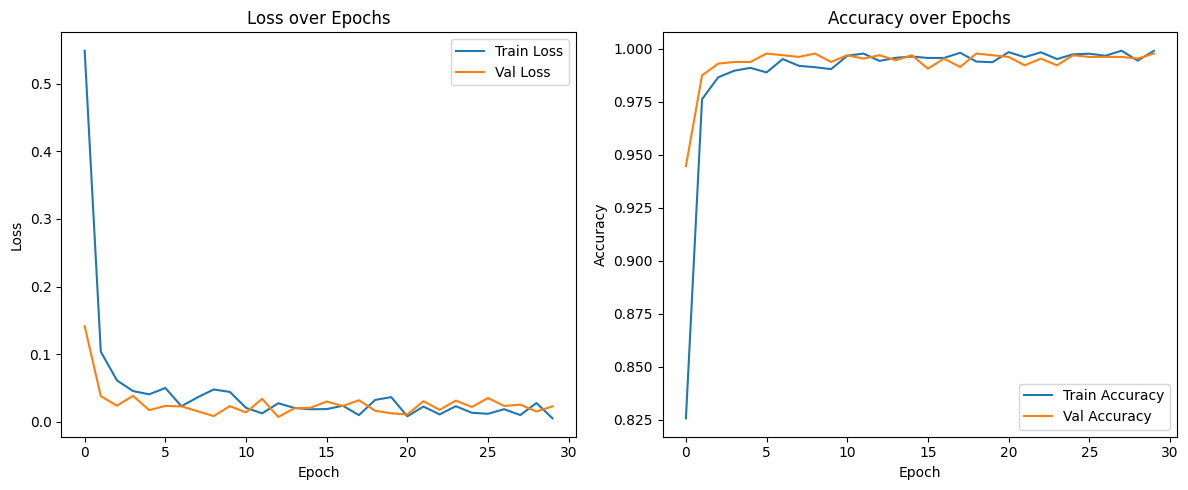

In [3]:
# ===========================
# Model Training
# ===========================

# Directories
train_dir = "/kaggle/working/tertiary_split/train"
val_dir = "/kaggle/working/tertiary_split/val"
test_dir = "/kaggle/working/tertiary_split/test"

# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Datasets & Loaders
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
val_data = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_data = datasets.ImageFolder(test_dir, transform=val_test_transforms)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load InceptionV3
weights = Inception_V3_Weights.DEFAULT
model = inception_v3(weights=weights, aux_logits=True)

# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

# Modify final layers
model.AuxLogits.fc = nn.Linear(768, 3)
model.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 3)
)

model = model.to(device)

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_data.targets),
    y=train_data.targets
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training
num_epochs = 30
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    start_time = time.time()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, aux_outputs = model(images)
        loss1 = criterion(outputs, labels)
        loss2 = criterion(aux_outputs, labels)
        loss = loss1 + 0.4 * loss2
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), "best_model_inceptionv3.pth")

    elapsed = time.time() - start_time
    print(f"Epoch {epoch+1}/{num_epochs} - {int(elapsed)}s - "
          f"accuracy: {train_acc:.4f} - loss: {train_loss:.4f} - "
          f"val_accuracy: {val_acc:.4f} - val_loss: {val_loss:.4f}")

# Load best weights
model.load_state_dict(torch.load("best_model_inceptionv3.pth"))

# =========================== 
# Evaluation
# ===========================
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n",
      classification_report(all_labels, all_preds, target_names=train_data.classes))

# ===========================
# Plot
# ===========================
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


In [8]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.preprocessing import label_binarize
import torch
import numpy as np

# Load InceptionV3 and match training architecture
model = inception_v3(weights=Inception_V3_Weights.DEFAULT, aux_logits=True)

# Match classifier to training config
model.AuxLogits.fc = nn.Linear(768, 3)
model.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 3)
)

# Load trained weights
model.load_state_dict(torch.load("best_model_inceptionv3.pth"))
model = model.to(device)
model.eval()

# Evaluate on the test set
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert results to numpy arrays
y_pred_probs = np.array(all_probs)
y_true_bin = label_binarize(all_labels, classes=[0, 1, 2])

# Classification report and confusion matrix
class_names = test_data.classes
report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
conf_matrix = confusion_matrix(all_labels, all_preds)

# AUC Scores
auc_scores = roc_auc_score(y_true_bin, y_pred_probs, average=None)

# Sensitivity (Recall) & Specificity
sensitivity = []
specificity = []

for i in range(len(class_names)):
    TP = conf_matrix[i, i]
    FN = conf_matrix[i].sum() - TP
    FP = conf_matrix[:, i].sum() - TP
    TN = conf_matrix.sum() - (TP + FP + FN)

    sensitivity.append(TP / (TP + FN) * 100 if (TP + FN) > 0 else 0)
    specificity.append(TN / (TN + FP) * 100 if (TN + FP) > 0 else 0)

# Accuracy
acc = accuracy_score(all_labels, all_preds) * 100

# Print nicely formatted report
print("\nTest Performance of Tertiary Classification")
print(f"{'Metrics':<15}{'InceptionV3':>12}")
print("-" * 30)

for i, cls in enumerate(class_names):
    print(cls)
    print(f"{'AUC (%)':<15}{auc_scores[i]*100:>12.2f}")
    print(f"{'F1 score (%)':<15}{report[cls]['f1-score']*100:>12.2f}")
    print(f"{'Precision (%)':<15}{report[cls]['precision']*100:>12.2f}")
    print(f"{'Recall (%)':<15}{report[cls]['recall']*100:>12.2f}")
    print(f"{'Sensitivity (%)':<15}{sensitivity[i]:>12.2f}")
    print(f"{'Specificity (%)':<15}{specificity[i]:>12.2f}")
    print("-" * 30)

print(f"{'Overall Accuracy (%)':<20}{acc:.2f}")


/tmp/ipykernel_31/2103348327.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_inceptionv3.pth"))



Test Performance of Tertiary Classification
Metrics         InceptionV3
------------------------------
functional
AUC (%)              100.00
F1 score (%)          99.52
Precision (%)         99.68
Recall (%)            99.37
Sensitivity (%)       99.37
Specificity (%)       99.91
------------------------------
healthy
AUC (%)               99.98
F1 score (%)          99.68
Precision (%)         99.79
Recall (%)            99.57
Sensitivity (%)       99.57
Specificity (%)       99.64
------------------------------
organic
AUC (%)              100.00
F1 score (%)          99.37
Precision (%)         98.74
Recall (%)           100.00
Sensitivity (%)      100.00
Specificity (%)       99.76
------------------------------
Overall Accuracy (%)99.60


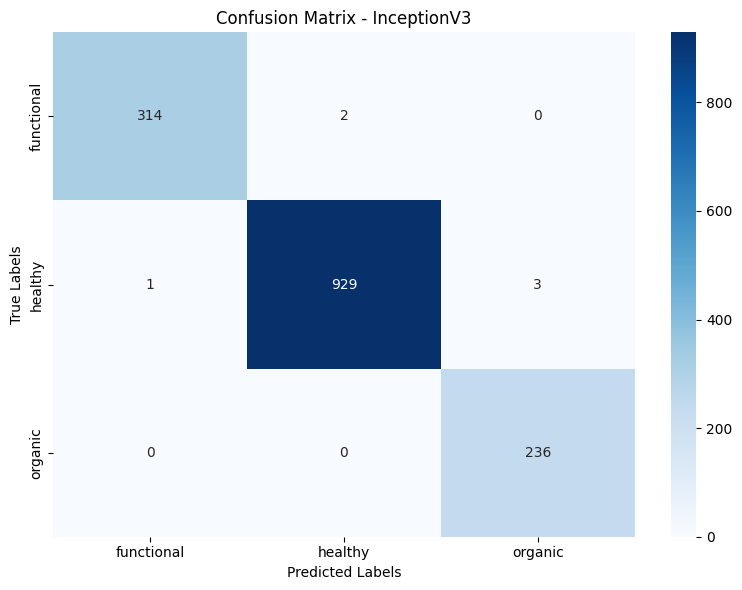

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title("Confusion Matrix - InceptionV3")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()



Validation Performance of Tertiary Classification
Metrics         InceptionV3
------------------------------
functional
AUC (%)              100.00
F1 score (%)          99.81
Precision (%)        100.00
Recall (%)            99.63
Sensitivity (%)       99.63
Specificity (%)      100.00
------------------------------
healthy
AUC (%)               99.90
F1 score (%)          99.81
Precision (%)         99.87
Recall (%)            99.75
Sensitivity (%)       99.75
Specificity (%)       99.79
------------------------------
organic
AUC (%)               99.98
F1 score (%)          99.50
Precision (%)         99.01
Recall (%)           100.00
Sensitivity (%)      100.00
Specificity (%)       99.81
------------------------------
Overall Accuracy (%)99.76


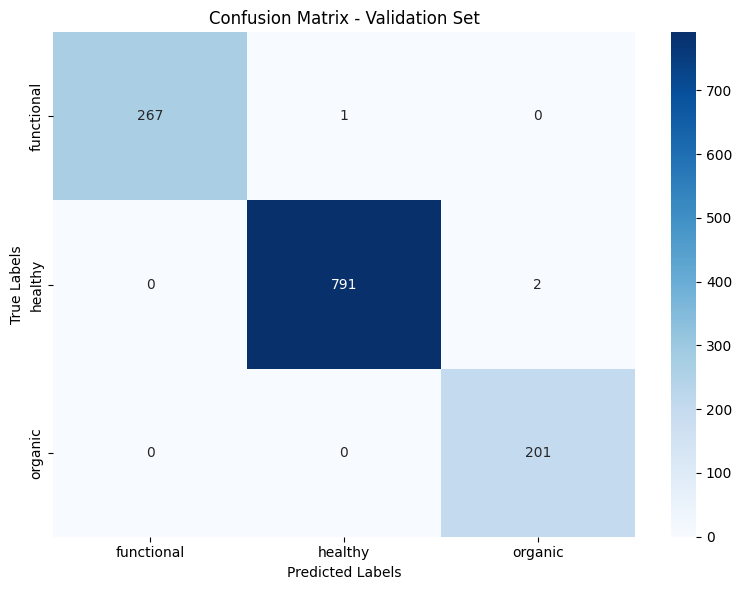

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.preprocessing import label_binarize
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate on the validation set
val_preds, val_labels, val_probs = [], [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)

        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())
        val_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
val_pred_probs = np.array(val_probs)
val_true_bin = label_binarize(val_labels, classes=[0, 1, 2])

# Metrics
val_class_names = val_data.classes
val_report = classification_report(val_labels, val_preds, target_names=val_class_names, output_dict=True)
val_conf_matrix = confusion_matrix(val_labels, val_preds)
val_auc_scores = roc_auc_score(val_true_bin, val_pred_probs, average=None)

# Sensitivity & Specificity
val_sensitivity = []
val_specificity = []

for i in range(len(val_class_names)):
    TP = val_conf_matrix[i, i]
    FN = val_conf_matrix[i].sum() - TP
    FP = val_conf_matrix[:, i].sum() - TP
    TN = val_conf_matrix.sum() - (TP + FP + FN)

    val_sensitivity.append(TP / (TP + FN) * 100 if (TP + FN) > 0 else 0)
    val_specificity.append(TN / (TN + FP) * 100 if (TN + FP) > 0 else 0)

# Accuracy
val_acc = accuracy_score(val_labels, val_preds) * 100

# Print nicely formatted report
print("\nValidation Performance of Tertiary Classification")
print(f"{'Metrics':<15}{'InceptionV3':>12}")
print("-" * 30)

for i, cls in enumerate(val_class_names):
    print(cls)
    print(f"{'AUC (%)':<15}{val_auc_scores[i]*100:>12.2f}")
    print(f"{'F1 score (%)':<15}{val_report[cls]['f1-score']*100:>12.2f}")
    print(f"{'Precision (%)':<15}{val_report[cls]['precision']*100:>12.2f}")
    print(f"{'Recall (%)':<15}{val_report[cls]['recall']*100:>12.2f}")
    print(f"{'Sensitivity (%)':<15}{val_sensitivity[i]:>12.2f}")
    print(f"{'Specificity (%)':<15}{val_specificity[i]:>12.2f}")
    print("-" * 30)

print(f"{'Overall Accuracy (%)':<20}{val_acc:.2f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=val_class_names, yticklabels=val_class_names)
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


In [12]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# If history is a dictionary, we can directly convert it to a DataFrame
history_df = pd.DataFrame(history)
history_df.to_csv("accuracy_loss_perinception_tertiary_epoch.csv", index=False)

# Binarize labels for ROC curve (One-hot encode true labels)
n_classes = 3
y_true_bin = label_binarize(all_labels, classes=[0, 1, 2])  # Replace y_true with all_labels

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])  # y_pred_probs should be a numpy array
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Save ROC values to CSV
roc_data = []

class_names = ["Class 0", "Class 1", "Class 2"]  # Replace with your actual class names if different

for i in range(n_classes):
    for fp, tp in zip(fpr[i], tpr[i]):
        roc_data.append({"class": class_names[i], "fpr": fp, "tpr": tp, "auc": roc_auc[i]})

# Micro average
for fp, tp in zip(fpr["micro"], tpr["micro"]):
    roc_data.append({"class": "micro", "fpr": fp, "tpr": tp, "auc": roc_auc["micro"]})

roc_df = pd.DataFrame(roc_data)
roc_df.to_csv("roc_values_inception_tertiary.csv", index=False)
